In [3]:
# train_vit.py
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["USE_TORCH"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import glob
import random

# ========== CONFIG ==========
DATA_DIR = r"C:\Users\ksiva\Desktop\Deepfake-Detection\dataset"  # path to your dataset folder
OUTPUT_DIR = "./vit-deepfake-model"
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
# =============================

# Custom Dataset Class
class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        
        if split == 'train':
            # For training, use the train directory
            self.fake_images = glob.glob(os.path.join(data_dir, 'train', 'Fake', '*.jpg'))
            # We need real images for training too, let's use some from test
            self.real_images = glob.glob(os.path.join(data_dir, 'test', 'real', '*.jpg'))
            # Take only a subset of real images to balance the dataset
            self.real_images = self.real_images[:len(self.fake_images)]
        else:
            # For testing, use the test directory
            self.fake_images = glob.glob(os.path.join(data_dir, 'test', 'fake', '*.jpg'))
            self.real_images = glob.glob(os.path.join(data_dir, 'test', 'real', '*.jpg'))
        
        # Combine and shuffle
        self.images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        
        # Shuffle data
        combined = list(zip(self.images, self.labels))
        random.shuffle(combined)
        self.images, self.labels = zip(*combined)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Simple CNN Model (since ViT has dependency issues)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading dataset from:", DATA_DIR)
train_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='train')
test_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = SimpleCNN(num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_model():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# Evaluation function
def evaluate_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            all_preds.extend(pred.cpu().numpy().flatten())
            all_labels.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(test_loader)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    
    return avg_loss, accuracy, precision, recall, f1

# Training loop
print("\nStarting training...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_model()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    val_loss, val_acc, precision, recall, f1 = evaluate_model()
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Save model
print("\nSaving model to:", OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'model.pth'))

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, 'r-', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, 'r-', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results_accuracy_curve.png")
plt.show()

print("\nTraining completed!")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Final Validation F1 Score: {f1:.4f}")


Loading dataset from: C:\Users\ksiva\Desktop\Deepfake-Detection\dataset

Starting training...

Epoch 1/5
Batch 0, Loss: 0.6932
Batch 10, Loss: 0.6339
Batch 20, Loss: 0.4599
Batch 30, Loss: 0.1215
Batch 40, Loss: 0.0553
Batch 50, Loss: 0.5108
Batch 60, Loss: 0.1600
Batch 70, Loss: 0.0548
Batch 80, Loss: 0.0904
Batch 90, Loss: 0.0680
Batch 100, Loss: 0.1000
Batch 110, Loss: 0.2523


KeyboardInterrupt: 

Loading dataset from: C:\Users\ksiva\Desktop\Deepfake-Detection\dataset

Starting training...

Epoch 1/5



--- Epoch 1 Summary ---
Train Loss: 0.2282, Train Acc: 92.94%
Val Loss: 1.2299, Val Acc: 51.62%
Precision: 0.5102, Recall: 0.9802, F1: 0.6711
Time for this epoch: 1:44:34
Elapsed: 1:44:34, Estimated time left: 6:58:17

Epoch 2/5



--- Epoch 2 Summary ---
Train Loss: 0.1964, Train Acc: 93.55%
Val Loss: 0.9526, Val Acc: 58.08%
Precision: 0.5621, Recall: 0.7595, F1: 0.6460
Time for this epoch: 1:57:03
Elapsed: 3:41:37, Estimated time left: 5:32:25

Epoch 3/5



--- Epoch 3 Summary ---
Train Loss: 0.1695, Train Acc: 94.19%
Val Loss: 0.9613, Val Acc: 60.91%
Precision: 0.5780, Recall: 0.8288, F1: 0.6811
Time for this epoch: 0:36:03
Elapsed: 4:17:40, Estimated time left: 2:51:47

Epoch 4/5



--- Epoch 4 Summary ---
Train Loss: 0.1543, Train Acc: 94.62%
Val Loss: 0.9210, Val Acc: 63.62%
Precision: 0.6000, Recall: 0.8328, F1: 0.6975
Time for this epoch: 1:44:59
Elapsed: 6:02:39, Estimated time left: 1:30:39

Epoch 5/5



--- Epoch 5 Summary ---
Train Loss: 0.1402, Train Acc: 94.99%
Val Loss: 0.7210, Val Acc: 67.83%
Precision: 0.6570, Recall: 0.7558, F1: 0.7030
Time for this epoch: 1:04:18
Elapsed: 7:06:58, Estimated time left: 0:00:00

Saving model to: ./vit-deepfake-model


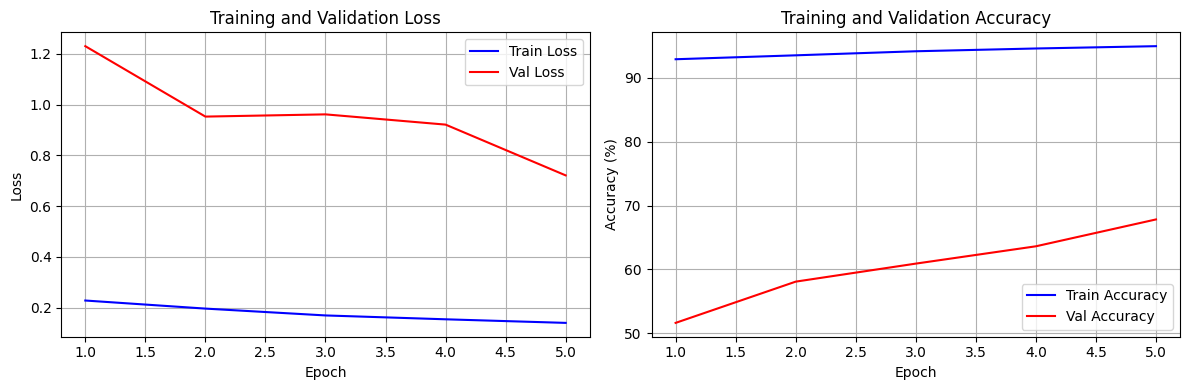


Training completed!
Final Validation Accuracy: 67.83%
Final Validation F1 Score: 0.7030


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["USE_TORCH"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import glob
import random
import time
from datetime import timedelta
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = r"C:\Users\ksiva\Desktop\Deepfake-Detection\dataset"  # path to your dataset folder
OUTPUT_DIR = "./vit-deepfake-model"
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
# =============================

# Custom Dataset Class
class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        
        if split == 'train':
            self.fake_images = glob.glob(os.path.join(data_dir, 'train', 'Fake', '*.jpg'))
            self.real_images = glob.glob(os.path.join(data_dir, 'test', 'real', '*.jpg'))
            self.real_images = self.real_images[:len(self.fake_images)]
        else:
            self.fake_images = glob.glob(os.path.join(data_dir, 'test', 'fake', '*.jpg'))
            self.real_images = glob.glob(os.path.join(data_dir, 'test', 'real', '*.jpg'))
        
        self.images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        
        combined = list(zip(self.images, self.labels))
        random.shuffle(combined)
        self.images, self.labels = zip(*combined)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading dataset from:", DATA_DIR)
train_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='train')
test_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = SimpleCNN(num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function with tqdm progress bar
def train_model():
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# Evaluation function
def evaluate_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            all_preds.extend(pred.cpu().numpy().flatten())
            all_labels.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(test_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    return avg_loss, accuracy, precision, recall, f1

# Training loop with ETA
print("\nStarting training...")
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_model()
    val_loss, val_acc, precision, recall, f1 = evaluate_model()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    elapsed = epoch_end - start_time
    avg_epoch_time = elapsed / (epoch + 1)
    remaining_time = avg_epoch_time * (EPOCHS - (epoch + 1))

    print(f"\n--- Epoch {epoch+1} Summary ---")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Time for this epoch: {timedelta(seconds=int(epoch_duration))}")
    print(f"Elapsed: {timedelta(seconds=int(elapsed))}, Estimated time left: {timedelta(seconds=int(remaining_time))}")

# Save model
print("\nSaving model to:", OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'model.pth'))

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, 'r-', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, 'r-', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results_accuracy_curve.png")
plt.show()

print("\nTraining completed!")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Final Validation F1 Score: {f1:.4f}")


In [37]:
from PIL import Image
import torch
import numpy as np

# Load the trained PyTorch model weights
model.load_state_dict(torch.load("./vit-deepfake-model/model.pth", map_location=device))
model.eval()

img_path = "dataset/test/real/real_8.jpg"  # or real sample
img = Image.open(img_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    pred = torch.softmax(output, dim=1)[0][1].item()  # Probability for 'fake' class

if pred > 0.5:
    print("🔴 Fake Image Detected")
else:
    print("🟢 Real Image Detected")


🟢 Real Image Detected


In [10]:
import torch

# Save PyTorch model weights
torch.save(model.state_dict(), "vit-deepfake-model.pth")  # ✅ PyTorch format


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["USE_TORCH"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import glob
import random
import time
from datetime import timedelta
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = r"C:\Users\ksiva\Desktop\Deepfake-Detection\dataset"
OUTPUT_DIR = "./vit-deepfake-model"
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "model.pth")
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
# =============================

# Custom Dataset Class
class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split

        if split == 'train':
            self.fake_images = glob.glob(os.path.join(data_dir, 'train', 'Fake', '*.jpg'))
            self.real_images = glob.glob(os.path.join(data_dir, 'train', 'Real', '*.jpg'))
        else:
            self.fake_images = glob.glob(os.path.join(data_dir, 'test', 'fake', '*.jpg'))
            self.real_images = glob.glob(os.path.join(data_dir, 'test', 'real', '*.jpg'))

        self.images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

        combined = list(zip(self.images, self.labels))
        random.shuffle(combined)
        self.images, self.labels = zip(*combined)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
print("📂 Loading dataset from:", DATA_DIR)
train_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='train')
test_dataset = DeepfakeDataset(DATA_DIR, transform=transform, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = SimpleCNN(num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Trackers
train_losses, val_losses, val_accs = [], [], []
start_epoch = 0

# 🔹 Load checkpoint if it exists
# 🔹 Load existing model or checkpoint
if os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 Found existing model at {CHECKPOINT_PATH}. Loading...")

    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    
    # Check if it's a full checkpoint (dict with keys) or just raw model weights
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_accs = checkpoint.get('val_accs', [])
        print(f"✅ Resumed from epoch {start_epoch}")
    else:
        # It's just raw model weights
        model.load_state_dict(checkpoint)
        start_epoch = 0
        print("✅ Loaded raw model weights. Starting training from epoch 0.")
else:
    print("🆕 No saved model found. Starting training from scratch.")
    start_epoch = 0


# Training and Evaluation
def train_model():
    model.train()
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    return total_loss / len(train_loader), 100. * correct / total


def evaluate_model():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy().flatten())
            all_labels.extend(target.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    acc = 100. * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    return avg_loss, acc, precision, recall, f1


# 🔁 Continuous training
print("\n🚀 Starting continuous training (Press Ctrl + C to stop)...")
os.makedirs(OUTPUT_DIR, exist_ok=True)

epoch = start_epoch
try:
    while True:
        epoch += 1
        print(f"\n===== Epoch {epoch} =====")
        start_time = time.time()

        train_loss, train_acc = train_model()
        val_loss, val_acc, precision, recall, f1 = evaluate_model()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        elapsed = timedelta(seconds=int(time.time() - start_time))
        print(f"📊 Epoch {epoch} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print(f"⏱ Time: {elapsed}")

        # 🔒 Save checkpoint safely
        temp_path = CHECKPOINT_PATH + ".tmp"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accs': val_accs
        }, temp_path)
        os.replace(temp_path, CHECKPOINT_PATH)
        print(f"💾 Checkpoint saved at epoch {epoch} -> {CHECKPOINT_PATH}")

except KeyboardInterrupt:
    print("\n🛑 Training stopped manually. Checkpoint saved safely.")

# 📈 Plot after training stops
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

print("\n✅ Training session completed. Latest checkpoint saved.")


📂 Loading dataset from: C:\Users\ksiva\Desktop\Deepfake-Detection\dataset


C:\Users\ksiva\AppData\Local\Temp\ipykernel_19916\1113002262.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=devi

🔄 Found existing model at ./vit-deepfake-model\model.pth. Loading...
✅ Resumed from epoch 8

🚀 Starting continuous training (Press Ctrl + C to stop)...

===== Epoch 9 =====


Training:  31%|███       | 540/1751 [07:05<11:14,  1.80it/s, loss=0.1510]

In [1]:
import torch
print(torch.version.cuda)          # Should show CUDA version, e.g., '12.2'
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show RTX 4050


12.1
True
True
NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["USE_TORCH"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import glob, random, time
from datetime import timedelta
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = r"C:\Users\ksiva\Desktop\Deepfake-Detection\dataset"
OUTPUT_DIR = "./vit-deepfake-model"
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "model.pth")
LEARNING_RATE = 1e-4
MAX_EPOCHS = 30        # stop after 30 epochs (you can change this)
# ============================

# ---------- Dataset ----------
class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split

        self.fake_images = glob.glob(os.path.join(data_dir, split, 'Fake', '*.jpg'))
        if not self.fake_images:  # handle lowercase folders
            self.fake_images = glob.glob(os.path.join(data_dir, split, 'fake', '*.jpg'))

        self.real_images = glob.glob(os.path.join(data_dir, split, 'Real', '*.jpg'))
        if not self.real_images:
            self.real_images = glob.glob(os.path.join(data_dir, split, 'real', '*.jpg'))

        self.images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

        combined = list(zip(self.images, self.labels))
        random.shuffle(combined)
        self.images, self.labels = zip(*combined)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------- Model ----------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ---------- Transforms ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------- Device ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Using device: {device}")

# ---------- Auto Batch Size Test ----------
def find_best_batch_size(model, device, base=16):
    test_input = torch.randn(base, 3, 224, 224).to(device)
    while True:
        try:
            _ = model(test_input)
            base += 8
            test_input = torch.randn(base, 3, 224, 224).to(device)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                base -= 8
                break
    print(f"✅ Best batch size that fits: {base}")
    return base

model = SimpleCNN().to(device)

model = SimpleCNN().to(device)

def safe_find_best_batch_size(model, device, start=32, step=4, max_try=64):
    batch = start
    while batch <= max_try:
        try:
            x = torch.randn(batch, 3, 224, 224, device=device)
            with torch.no_grad():
                _ = model(x)
            torch.cuda.empty_cache()
            batch += step
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                batch -= step
                print(f"✅ Best batch size that fits: {batch}")
                return batch
            else:
                raise
    print(f"✅ Max batch size {max_try} fits fine.")
    return max_try

BATCH_SIZE = safe_find_best_batch_size(model, device)


# ---------- Data ----------
print("📂 Loading dataset...")
train_dataset = DeepfakeDataset(DATA_DIR, transform, 'train')
test_dataset  = DeepfakeDataset(DATA_DIR, transform, 'test')
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ---------- Optimizer & Loss ----------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()  # mixed precision

train_losses, val_losses, val_accs = [], [], []
start_epoch = 0

# ---------- Load checkpoint if exists ----------
if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        start_epoch = ckpt.get("epoch", 0) + 1
        train_losses = ckpt.get("train_losses", [])
        val_losses = ckpt.get("val_losses", [])
        val_accs = ckpt.get("val_accs", [])
        print(f"🔄 Resumed from epoch {start_epoch}")
    else:
        model.load_state_dict(ckpt)
        print("✅ Loaded raw weights.")

# ---------- Training ----------
def train_one_epoch():
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc="Training", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(x)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = output.argmax(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)
        loop.set_postfix(loss=f"{loss.item():.4f}")
    return total_loss / len(train_loader), 100 * correct / total

@torch.no_grad()
def evaluate():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    for x, y in tqdm(test_loader, desc="Evaluating", leave=False):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        preds = out.argmax(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    acc = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary", zero_division=0
    )
    return avg_loss, acc, precision, recall, f1

# ---------- Main Loop ----------
os.makedirs(OUTPUT_DIR, exist_ok=True)
for epoch in range(start_epoch + 1, start_epoch + MAX_EPOCHS + 1):
    start = time.time()
    print(f"\n===== Epoch {epoch} =====")
    tr_loss, tr_acc = train_one_epoch()
    val_loss, val_acc, prec, rec, f1 = evaluate()

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    elapsed = timedelta(seconds=int(time.time() - start))
    print(f"📊 Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%")
    print(f"📈 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print(f"⏱ Duration: {elapsed}")

    # Save checkpoint
    tmp = CHECKPOINT_PATH + ".tmp"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs
    }, tmp)
    os.replace(tmp, CHECKPOINT_PATH)
    print(f"💾 Checkpoint saved at epoch {epoch}")

print("\n✅ Training completed successfully.")

# ---------- Plot ----------
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.grid(True); plt.xlabel("Epoch"); plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accs, label="Val Accuracy")
plt.legend(); plt.grid(True); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()


🔥 Using device: cuda
✅ Max batch size 64 fits fine.
📂 Loading dataset...


C:\Users\ksiva\AppData\Local\Temp\ipykernel_24132\1366128903.py:149: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # mixed precision
C:\Users\ksiva\AppData\Local\Temp\ipykernel_24132\1366128903.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

🔄 Resumed from epoch 2

===== Epoch 3 =====


Training:   0%|          | 0/2188 [00:00<?, ?it/s]